Для работы с текстом необходимо иметь некий массив текста достаточно большого размера. И таким источником является Wiki. Так что рассмотрим, как мы можем забрать эту информацию.

# Presets

Для парсинга xml будем использовать [mwxml](https://pythonhosted.org/mwxml/)

In [5]:
!pip install mwxml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=8d1e1b91a4aa4e2dc654c13b8d0e48a4a2cc324abf7f74941928479217c14d28
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


Чтобы создать вики-представление текста, мы передаем текст статьи из Википедии в mwparserfromhell.

Чтобы выяснить все, что вы можете сделать с mwparserfromhell, [прочитайте документацию](https://mwparserfromhell.readthedocs.io/en/latest/).

In [6]:
!pip install mwparserfromhell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.0 MB/s eta 0:00:00


Монтируем диск Google

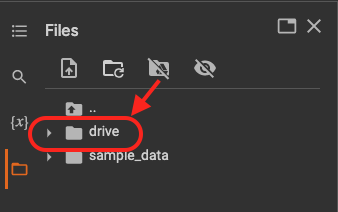

# Form candidate list

Загружать данные будем из дампов  Wiki

In [7]:
import requests

# Parsing HTML
from bs4 import BeautifulSoup

# File system management
import os

In [8]:
base_url = 'https://dumps.wikimedia.org/ruwiki/'
index = requests.get(base_url).text
soup_index = BeautifulSoup(index, 'html.parser')

# Find the links that are dates of dumps
dumps = [a['href'] for a in soup_index.find_all('a') if 
         a.has_attr('href')]
dumps

['../',
 '20230120/',
 '20230201/',
 '20230220/',
 '20230301/',
 '20230320/',
 '20230401/',
 '20230420/',
 '20230501/',
 'latest/']

Выберем самый свежий дамп

In [9]:
# Get lastest dump
dump_url = base_url + 'latest/'

# Retrieve the html
dump_html = requests.get(dump_url).text
dump_html[:10]

'<html>\r\n<h'

In [10]:
# Convert to a soup
soup_dump = BeautifulSoup(dump_html, 'html.parser')

# Find li elements with the class file
soup_dump.find_all('a', href=True, limit = 10)[:4]

[<a href="../">../</a>,
 <a href="ruwiki-latest-abstract.xml.gz">ruwiki-latest-abstract.xml.gz</a>,
 <a href="ruwiki-latest-abstract.xml.gz-rss.xml">ruwiki-latest-abstract.xml.gz-rss.xml</a>,
 <a href="ruwiki-latest-abstract1.xml.gz">ruwiki-latest-abstract1.xml.gz</a>]

Получим список дампов

In [11]:
# List of dumps
for file in soup_dump.find_all('a', href=True):
    text = file['href']
    if 'pages-articles' in text:
      print(text)

ruwiki-latest-pages-articles-multistream-index.txt.bz2
ruwiki-latest-pages-articles-multistream-index.txt.bz2-rss.xml
ruwiki-latest-pages-articles-multistream-index1.txt-p1p224167.bz2
ruwiki-latest-pages-articles-multistream-index1.txt-p1p224167.bz2-rss.xml
ruwiki-latest-pages-articles-multistream-index2.txt-p224168p1042043.bz2
ruwiki-latest-pages-articles-multistream-index2.txt-p224168p1042043.bz2-rss.xml
ruwiki-latest-pages-articles-multistream-index3.txt-p1042044p2198269.bz2
ruwiki-latest-pages-articles-multistream-index3.txt-p1042044p2198269.bz2-rss.xml
ruwiki-latest-pages-articles-multistream-index4.txt-p2198270p3698269.bz2
ruwiki-latest-pages-articles-multistream-index4.txt-p2198270p3698269.bz2-rss.xml
ruwiki-latest-pages-articles-multistream-index4.txt-p3698270p3835772.bz2
ruwiki-latest-pages-articles-multistream-index4.txt-p3698270p3835772.bz2-rss.xml
ruwiki-latest-pages-articles-multistream-index5.txt-p3835773p5335772.bz2
ruwiki-latest-pages-articles-multistream-index5.txt-p38

In [12]:
# Filter files
files = []

# Search through all files
for file in soup_dump.find_all('a', href=True):
    text = file['href']
    
    # Select the relevant files
    if 'pages-articles' in text and 'bz2-rss' not in text:
        files.append((text.split()[0], text.split()[1:]))

files[:5]

[('ruwiki-latest-pages-articles-multistream-index.txt.bz2', []),
 ('ruwiki-latest-pages-articles-multistream-index1.txt-p1p224167.bz2', []),
 ('ruwiki-latest-pages-articles-multistream-index2.txt-p224168p1042043.bz2',
  []),
 ('ruwiki-latest-pages-articles-multistream-index3.txt-p1042044p2198269.bz2',
  []),
 ('ruwiki-latest-pages-articles-multistream-index4.txt-p2198270p3698269.bz2',
  [])]

Сформируем список файлов для загрузки

In [13]:
# Form list of files for download
# Select multi-volume dump with articles
files_to_download = [file[0] for file in files if '.xml-p' in file[0]]
files_to_download[-5:]

['ruwiki-latest-pages-articles5.xml-p5335773p6585765.bz2',
 'ruwiki-latest-pages-articles6.xml-p6585766p8085765.bz2',
 'ruwiki-latest-pages-articles6.xml-p8085766p9585765.bz2',
 'ruwiki-latest-pages-articles6.xml-p9585766p10177887.bz2',
 'ruwiki-latest-pages-articles6.xml-p9585766p10192397.bz2']

# Download files of Wiki Data

Для загрузки фалов воспользуемя `get_file` утилитой из библиотеки `keras`

In [14]:
import sys
from keras.utils import get_file

### Parameters

В переменной `keras_home` укажем, куда будут сохраняться файлы<br>
в переменной `datasets` укажем папку для хранения датасетов<br>
в переменной `archives` укажем папку для хранения архивов

In [15]:
#%%writefile parameters.py

keras_home = '/content/drive/MyDrive/Data/Wiki/articles/'
datasets = 'datasets/'
archives = 'archive/'

%load parameters.py

После выполнения этой команды в ячейке появится содержимое файла parameters.py. Чтобы исполнить этот код, нужно удалить символы комментария (#) перед нужными строками и нажать Shift+Enter.


---

In [73]:
#%%writefile processfiles.py
data_paths = []
file_info = []

# Iterate through each file
for file in files_to_download:
    path = keras_home +datasets+ file
    
    # Check to see if the path exists (if the file is already downloaded)
    if not os.path.exists(path): #(keras_home + file):
        print('Downloading')
        # If not, download the file
        data_paths.append(get_file(origin = dump_url+file, cache_dir= keras_home))
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))
        
    # If the file is already downloaded find some information
    else:
        data_paths.append(path)
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_number = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_number))

Downloading
68562895/68562895 [==============================] - 17s 0us/step


Какой самый большой файл? Мы можем использовать `sorted` для сортировки по размеру файла.Какой самый большой файл? Мы можем использовать `sorted` для сортировки по размеру файла.

In [79]:
sorted(file_info, key = lambda x: x[1], reverse = True)[:5]

[('ruwiki-latest-pages-articles-multistream5.xml-p3835773p5335772.bz2',
  788.431722,
  1499999),
 ('ruwiki-latest-pages-articles-multistream4.xml-p2198270p3698269.bz2',
  760.265323,
  1499999),
 ('ruwiki-latest-pages-articles5.xml-p3835773p5335772.bz2',
  756.775388,
  1499999),
 ('ruwiki-latest-pages-articles4.xml-p2198270p3698269.bz2',
  733.609441,
  1499999),
 ('ruwiki-latest-pages-articles-multistream6.xml-p6585766p8085765.bz2',
  727.746752,
  1499999)]

Эти размеры указаны в МБ. Похоже, что самые большие файлы сжаты примерно на 700 МБ.Эти размеры указаны в МБ. Похоже, что самые большие файлы сжаты примерно на 700 МБ.

In [ ]:
sorted(file_info, key = lambda x: x[2], reverse = True)[:5]

Опять же, я не знаю, что означают числа после p, но самая распространенная разница между первым и вторым — 1_500_000.

In [19]:
print(f'There are {len(file_info)} partitions.')

There are 22 partitions.


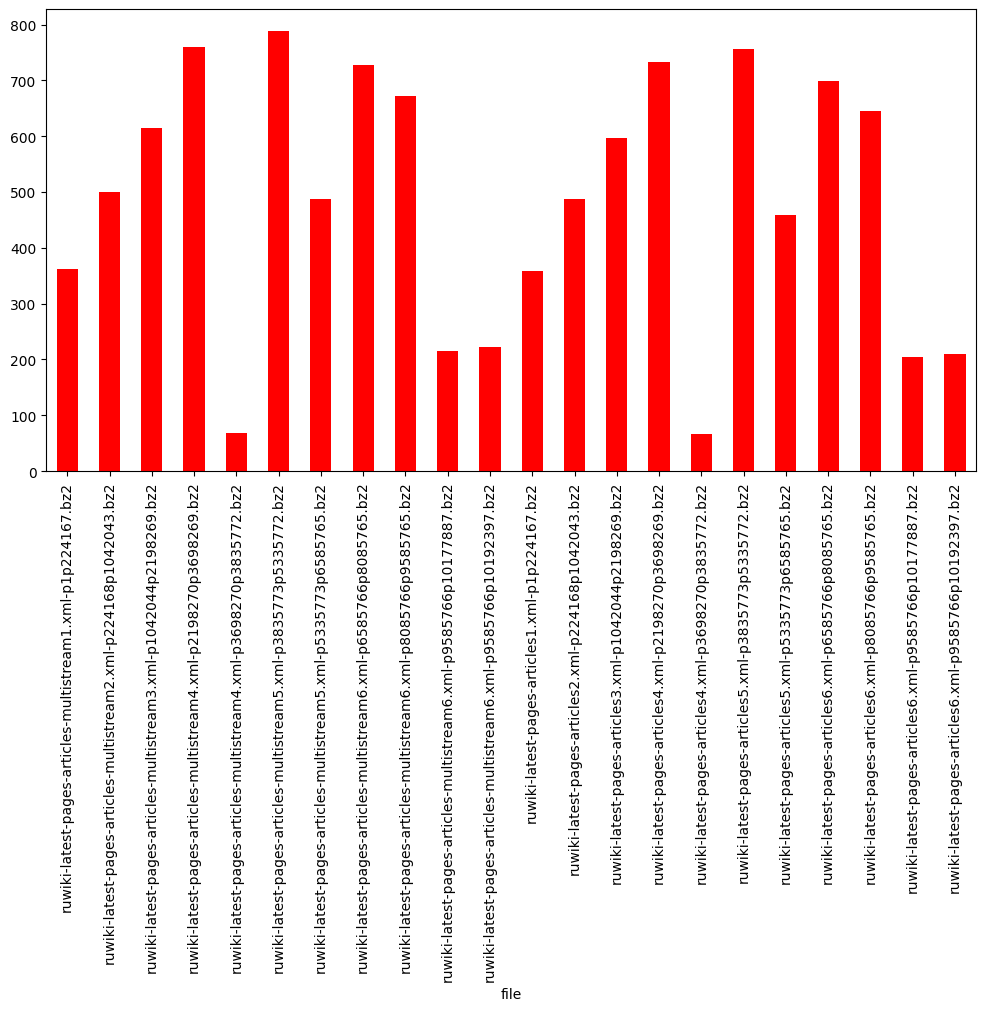

In [78]:
# Draw figure
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
file_df = pd.DataFrame(file_info, columns = ['file', 'size (MB)', 'articles']).set_index('file')
file_df['size (MB)'].plot.bar(color = 'red', figsize = (12, 6));

---

# Parse file

In [22]:
# Take shorttest dump
data_path = data_paths[4]
# File with that will work
data_path

'/content/drive/MyDrive/Data/Wiki/articles/datasets/ruwiki-latest-pages-articles-multistream4.xml-p3698270p3835772.bz2'

## Parsing XML

In [23]:
import xml.sax

class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Content handler for Wiki XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text', 'timestamp'):
            self._current_tag = name
            self._buffer = []
            #print(f'open tag {name} \n')

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            self._pages.append((self._values['title'], self._values['text']))
        #print(f'close tag {name} \n')

## Parsing Articles

In [21]:
import subprocess

In [40]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 50 articles have been found
#    if len(handler._pages) > 50:
#        break

In [48]:
def parseArticles(data_path):
  # Object for handling xml
  handler = WikiXmlHandler()

  # Parsing object
  parser = xml.sax.make_parser()
  parser.setContentHandler(handler)

  for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
  
  return handler

In [30]:
import mwparserfromhell 

In [31]:
def process_article(title, text, timestamp):
    """Process a wikipedia article"""
    # Create a parsing object
    wikicode = mwparserfromhell.parse(text)
    return (title, wikicode.strip_code().strip(), timestamp)

## Process Bulk Pages

Будем сохранять распарсеные файлы в один большой архив, с которым проще иметь дело, чем с кучей мелких файлов

In [26]:
import zipfile

In [27]:
stopTitle=('Файл:','Категория:','Википедия:','MediaWiki:','Шаблон:','Портал:','Проект:')
stopText=('перенаправление','REDIRECT','redirect','Redirect')

не предпочтительный способ выгрузки

In [28]:
def pocessBundleZip(pages, archive_name = 'archive.zip'):
  """Save exctacted wikipedia article in zip file"""
  with zipfile.ZipFile(archive_name, mode="a") as archive:
    for page_no,page in enumerate(pages):
      title, wikitext,_ = process_article(pages[page_no][0],pages[page_no][1],None)
      if not title.startswith(stopTitle):
        if not wikitext.startswith(stopText):
          fname = title.replace(', ',' ').replace('/','-')+'.txt'
          text = wikitext.replace('< ref >  < /ref >','').replace('< ref >','(').replace('< /ref >',')').replace('  .','.').replace('  ,',',').replace(' .','.')
          with archive.open(fname, "w") as new_file:
            new_file.write(bytes(text,'utf-8'))

предпочтительный способ выгрузки

In [55]:
def pocessBundleBZ2(pages, archive_name = 'archive.bz2'):
  """Save exctacted wikipedia article in bzip file"""
  with zipfile.ZipFile(archive_name, mode="a", compression=zipfile.ZIP_BZIP2) as archive:
    for page_no,page in enumerate(pages):
      title, wikitext,_ = process_article(pages[page_no][0],pages[page_no][1],None)
      if not title.startswith(stopTitle):
        if not wikitext.startswith(stopText):
          fname = title.replace(', ',' ').replace('/','-')+'.txt'
          text = wikitext.replace('< ref >  < /ref >','').replace('< ref >','(').replace('< /ref >',')').replace('  .','.').replace('  ,',',').replace(' .','.')
          with archive.open(fname, "w") as new_file:
            new_file.write(bytes(text,'utf-8'))

In [56]:
# Process Articles
handler = parseArticles(data_path)
# Get dump name
filename = os.path.splitext(os.path.basename(data_path))[0]
# Set Archive name
archName = keras_home + archives + filename + '.bz2'
# Save processed articles in archive
pocessBundleBZ2(handler._pages, archName)

In [ ]:
# Check created file
with zipfile.ZipFile(archName, mode="r",compression=zipfile.ZIP_BZIP2) as archive:
  #archive.printdir()
  print("------")
  text = archive.read("Джимасар.txt").decode(encoding="utf-8")

print(text)

In [ ]:
for page_no,page in enumerate(pages):
      title, wikitext,_ = process_article(pages[page_no][0],pages[page_no][1],None)
      print(f'')